# Beyond QUBO and HOBO formulations, solving the Travelling Salesman Problem on a quantum boson sampler
This Notebook demonstrates three alternative algorithms to solve the "travelling salesman" problem, where are courier must deliver packages in the most efficient manner to $N$ locations (or vertices), travelling to each location exactly once.  Further details are given in an [arXiv preprint](https://arxiv.org/abs/2406.14252).

The three solutions are simulated on the ORCA PT-1 photonic computer.  Distance data between locations is provided in a symmetric array.  This Notebook shows the critical importance of chosing a good embedding for a problem.

## Naive solution
In the [Lucas paper](https://arxiv.org/pdf/1302.5843), the problem is represented in the Ising formulation, equivalent to an array of binary numbers with $N$ rows and columns, and so $N^2$ elements.  If the array element $x_{v,i}$ where $v$ is the vertex and $i$ is the position in the cycle is $1$, when the $v$th vertex is in the $i$th position in the cycle.  The array element is $0$ otherwise.  For example, if there are four vertices then the array representing a solution where the vertices are followed in the order $0$, $1$, $3$, $2$ is

[1,0,0,0]\
[0,1,0,0]\
[0,0,0,1]\
[0,0,1,0]

Since each vertex can only appear in one position in the cycle, and each position in the cycle can only have one vertex, then each row and column of this array must have exactly one non-zero entry for the solution to be valid.  Since the first vertex can be fixed this can be coded with $(N-1)^2$ binary variable. This algorithm can be run by setting the constant `ALGORITHM = 1`.

This solution can be improved by "ORCA aware" solutions, which uses fewer binary variables, and has less "wasted" binary strings to which a penalty function is applied.

## ORCA aware algorithm 1
The problem is represented by $N$ binary numbers of length $log_2(N)$ where $N$ is the number of vertices.  For example, if there are four vertices then the array representing a solution where the vertices are followed in the order $0$, $1$, $3$, $2$ is

[0,0]\
[0,1]\
[1,1]\
[1,0]

Since the last entry is fully specified by the other entries this entry can be removed, and an ORCA bit string of [0,0,0,1,1,1] is sufficient to encode the solution.

The solution is found by minimising an objective function of a binary bit string generated by the ORCA PT-1.  

If the binary string is not a valid solution then a penalty `PENALTY` is applied.  The solution is not valid if a node appears more than once in the list, or is higher than a valid location.  Otherwise the objective function returns based on the distance travelled between nodes.  

ORCA produces a list of $(N-1)log_2(N)$ bits, which is mapped to a list of N-1 integers.

In general this approach requires a bit string of length $O(nlog(n))$ as compared to $O(N^2)$ for the naive solution.  This algorithm can be run by setting the constant `ALGORITHM = 2`.  However, this algorithm did not give good results for more locations, since many ORCA bit strings were outside the solution space, because they pointed to locations that were too high, or resulted in duplicate locations.

## Improved ORCA aware algorithm
In an improved algorithm the problem is represented by $N-1$ binary numbers where each binary number represents the next vertex to travel too.  As verteices are reached they are removed from the list of available vertices, so there are only $\sum_{i=1}^{N-1}log_2(i)$ binary variables required where $N$ is the number of vertices.

For example, if there are four vertices then a cycle is constructed as follows.  First, without loss of generality, $0$ is selected as the start of the cycle.  Then a binary number with two bits is processed and this identifies which of the three vertices is visited next.  Next a binary number with one bit is processed and this identifies the third vertex to be visited from the two vertices not yet visited.  There is no choice for the final vertex.  Only three bits are required in total, and so the problem can be represented by three binary variables.  

Since the binary number produced may be larger than the list of vertices not yet visited this number is converted to a valid index by dividing by the number of vertices left to be visited, and using the remainder as the index.  This is a potential flaw in the algorithm, since vertices with lower numbers are more likely to be selected.

No penalties need to be applied, since by design, the final list is always valid.  This algorithm can be run by setting the constant `ALGORITHM = 3`.

## Data used
Data sets are sourced from [a repository of Data for the Traveling Salesperson Problem](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html).  Based on the value of constant `LOCATIONS` a relevant data set is selected, and validated before use. The exception is the dataset with four nodes, which is the data set used in the Digital Catapult Quantum Technology Access Programme [QTAP](https://www.digicatapult.org.uk/about/press-releases/post/quantum-technology-access-programme-showcase/) use case.

In [1]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt

from ptseries.algorithms.binary_solvers import BinaryBosonicSolver
from ptseries.common.logger import Logger

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import prepare_first_list_of_locs, augment_loc_list, find_total_distance
from helper_functions_tsp import cost_fn_fact, find_problem_size, convert_PT_bit_string_to_cycle
from helper_functions_tsp import convert_PT_string_to_matrix, calculate_penalty_sums, calculate_distance

In [2]:
LOCATIONS = 5                #number of locations to be visited
LEARNING_RATE = 1e-2         #learning rate
UPDATES = 100                #updates, or iterations
PRINT_FREQUENCY = 20         #how often results are printed out
SPSA = False                 #SPSA stochastic gradient descent used
DEBUG = False                #Extra data printed out
ALGORITHM = 3                #1 = Naive, 2 = ORCA aware, 3 = Improved ORCA aware

In [3]:
if ALGORITHM not in [1,2,3]:
    raise Exception ('ALGORITHM MUST BE 1, 2 OR 3')

In [4]:
bin_len, pb_dim = find_problem_size(LOCATIONS, ALGORITHM)
if ALGORITHM == 1:
    print(f'In the naive formulation, the problem needs {LOCATIONS-1}**2 = {pb_dim} binary variables.')
else:
    print(f'In the ORCA aware formulation, the problem needs at most {bin_len} bits to hold the location as a binary number, and {pb_dim} binary variables.')

In the ORCA aware formulation, the problem needs at most 2 bits to hold the location as a binary number, and 5 binary variables.


In [5]:
data_sources = {  4 : {'file' : 'data/four_d.txt'},
                  5 : {'file' : 'data/five_d.txt'},
                 15 : {'file' : 'data/p01_d.txt'},
                 17 : {'file' : 'data/gr17_d.txt'},
                 26 : {'file' : 'data/fri26_d.txt'},
                 42 : {'file' : 'data/dantzig42_d.txt'},
                 48 : {'file' : 'data/att48_d.txt'}
                }

In [6]:
filename = read_file_name(LOCATIONS, data_sources)
print(f'Data will be read from filename {filename}')

Data will be read from filename data/five_d.txt


In [7]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

In [8]:
if ALGORITHM == 1:
    penalty = distance_array.max()
elif ALGORITHM == 2:
    approx_dist = np.sum(distance_array[0])
    penalty = 5 * approx_dist
elif ALGORITHM == 3:
    penalty = 0
else:
    raise Exception ('ALGORITHM MUST BE 1, 2 OR 3')
print(f'A penalty of {penalty} will be applied to invalid cycles')

A penalty of 0 will be applied to invalid cycles


In [9]:
logger = Logger(log_dir=None)

if SPSA:
    bbs = BinaryBosonicSolver(pb_dim,
                              cost_fn_fact(LOCATIONS,bin_len,distance_array,penalty,DEBUG,ALGORITHM),
                              tbi_params={"tbi_type": "single-loop"},
                              gradient_mode='spsa'
    )    
else:
    bbs = BinaryBosonicSolver(pb_dim,
                              cost_fn_fact(LOCATIONS,bin_len,distance_array,penalty,DEBUG,ALGORITHM),
                              tbi_params={"tbi_type": "single-loop"}
    )

bbs.train(
    learning_rate = LEARNING_RATE,
    updates = UPDATES,
    print_frequency = PRINT_FREQUENCY,
    logger=logger
)

Starting training...
Configuration 1 - M modes, M photons, parity 0
Training loop 20: loss is 24.12
Training loop 40: loss is 23.30
Training loop 60: loss is 23.00
Training loop 80: loss is 23.00
Training loop 100: loss is 23.00

Configuration 2 - M modes, M photons, parity 1
Training loop 20: loss is 21.00
Training loop 40: loss is 21.00
Training loop 60: loss is 21.00
Training loop 80: loss is 21.00
Training loop 100: loss is 21.00

Configuration 3 - M modes, M-1 photons, parity 0
Training loop 20: loss is 19.00
Training loop 40: loss is 19.00
Training loop 60: loss is 19.00
Training loop 80: loss is 19.00
Training loop 100: loss is 19.00

Configuration 4 - M modes, M-1 photons, parity 1
Training loop 20: loss is 23.80
Training loop 40: loss is 22.46
Training loop 60: loss is 22.02
Training loop 80: loss is 21.34
Training loop 100: loss is 21.04


In [10]:
out_name = f'graphs/alg_{ALGORITHM}_locs={LOCATIONS}_iterations={UPDATES}_SPSA={SPSA}_LR={LEARNING_RATE}.png'
graph_title = f'Algorithm {ALGORITHM} for {LOCATIONS} locations with {UPDATES} iterations, SPSA={SPSA}, LR = {LEARNING_RATE}'
print(f'A graph is saved to file {out_name}')

A graph is saved to file graphs/alg_3_locs=5_iterations=100_SPSA=False_LR=0.01.png


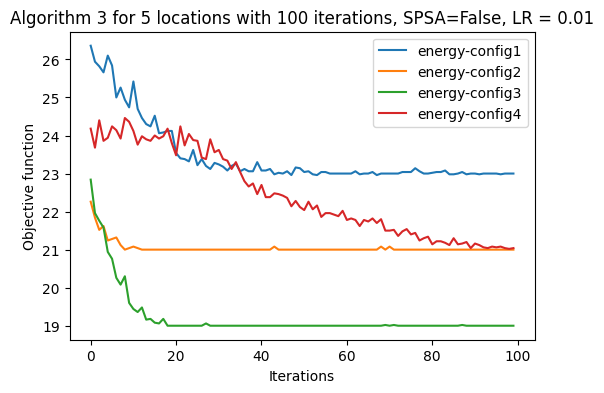

In [11]:
# Visualization
plt.figure(figsize=(6, 4))
for config in range(1, 5):
    key = f"energy-config{config}"
    plt.plot(logger.logs[key].keys(), logger.logs[key].values(), label=key)
plt.ylabel("Objective function")
plt.xlabel("Iterations")
plt.legend()
plt.title(graph_title)
plt.savefig(out_name) 
plt.show()

In [12]:
if ALGORITHM == 1:
    opt_sol = list(bbs.return_solution()[0])
    print(f'The optimum solution is with a bit string {opt_sol}')
    shaped_array = convert_PT_string_to_matrix(opt_sol, LOCATIONS)  
    penalty_sum1, penalty_sum2 = calculate_penalty_sums(shaped_array, LOCATIONS)
    distance = calculate_distance(shaped_array, distance_array, LOCATIONS)
    total = penalty * (penalty_sum1 + penalty_sum2) + distance
    print(f'The total distance and penalty {total}')
    print(f'The total distance is {distance}')
    print(f'This corresponds to an array of \n {shaped_array}')
else:
    if ALGORITHM == 2:
        opt_sol = np.array(bbs.return_solution()[0])
        print(f'The optimum solution is with a bit string {opt_sol}')
        first_list_of_locs = prepare_first_list_of_locs(opt_sol,bin_len)
        full_list_of_locs = augment_loc_list(first_list_of_locs, LOCATIONS)    
    if ALGORITHM == 3:
        print(f'The cycle distance is {bbs.return_solution()[1]}')
        opt_sol = list(bbs.return_solution()[0])
        print(f'The optimum solution is with a bit string {opt_sol}')
        full_list_of_locs = convert_PT_bit_string_to_cycle(opt_sol, LOCATIONS)
    print(f'This corresponds to a cycle of {full_list_of_locs}')
    print('The locations and distance for each leg are shown:')
    distance = find_total_distance(full_list_of_locs, LOCATIONS, distance_array, debug = True)
    print(f'For the optimum solution the distance is {distance}')

The cycle distance is 19.0
The optimum solution is with a bit string [0, 1, 0, 0, 1]
This corresponds to a cycle of [0, 2, 1, 4, 3]
The locations and distance for each leg are shown:
The distance from location 0 to location 2 is 4.0
The distance from location 2 to location 1 is 4.0
The distance from location 1 to location 4 is 3.0
The distance from location 4 to location 3 is 6.0
The distance from location 3 to location 0 is 2.0
For the optimum solution the distance is 19.0


In [13]:
print('The graph is saved to', out_name)

The graph is saved to graphs/alg_3_locs=5_iterations=100_SPSA=False_LR=0.01.png
